# Sales data visualisation 

In [3]:
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
import pandas as pd
import numpy as np

Note: you may need to restart the kernel to use updated packages.


# Sales 

In [4]:
# 1. Aggregate Sales by calendar year
# Use the cleaned source DataFrame `df` which contains 'Order_Date' and 'Sales'
# If `df` is not present in the current kernel, load the original source and perform minimal cleaning
if 'df' not in globals():
    url = 'https://drive.google.com/uc?id=1L8AUVWoSToH5dPQeVKo-LaWTbiaAsjwa&export=download'
    df = pd.read_csv(url)
    # normalize column names and parse order date (match earlier notebook steps)
    df = df.rename(columns=lambda s: s.strip().replace(' ', '_'))
    df['Order_Date'] = pd.to_datetime(df.get('Order_Date'), errors='coerce')
    # drop rows without an order date so aggregation won't fail
    df = df.dropna(subset=['Order_Date'])

if 'Order_Date' not in df.columns:
    raise KeyError("Order date column 'Order_Date' not found in df")
if 'Sales' not in df.columns:
    raise KeyError("Sales column not found in df")

sales_by_year = (
    df
    .assign(Year=df['Order_Date'].dt.year)
    .groupby('Year', as_index=False)['Sales']
    .sum()
    .sort_values('Year')
    .reset_index(drop=True)
)


# Line chart :  Total sales by year

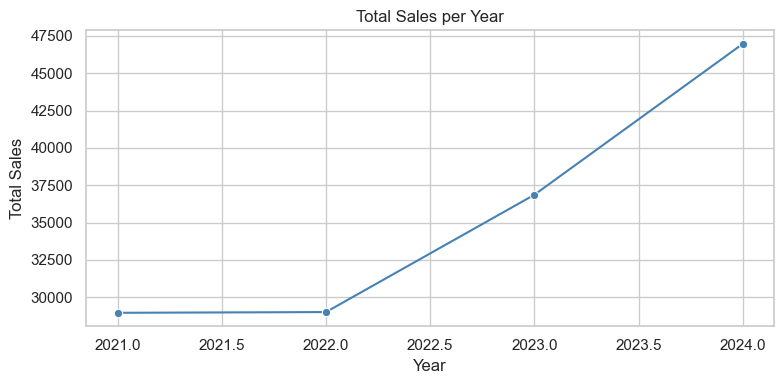

In [5]:
# Ensure dates are datetime (handle both possible column names)
if "Order_Date" in df.columns:
    df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
elif "Order Date" in df.columns:
    df["Order_Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
else:
    raise KeyError("Order date column not found in df. Expected 'Order_Date' or 'Order Date'.")

# Aggregate by calendar year
sales_by_year = (
    df
    .assign(Year=df["Order_Date"].dt.year)
    .groupby("Year", as_index=False)["Sales"]
    .sum()
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=sales_by_year, x="Year", y="Sales", marker="o", color="steelblue")
plt.title("Total Sales per Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


# Monthly sales by region 

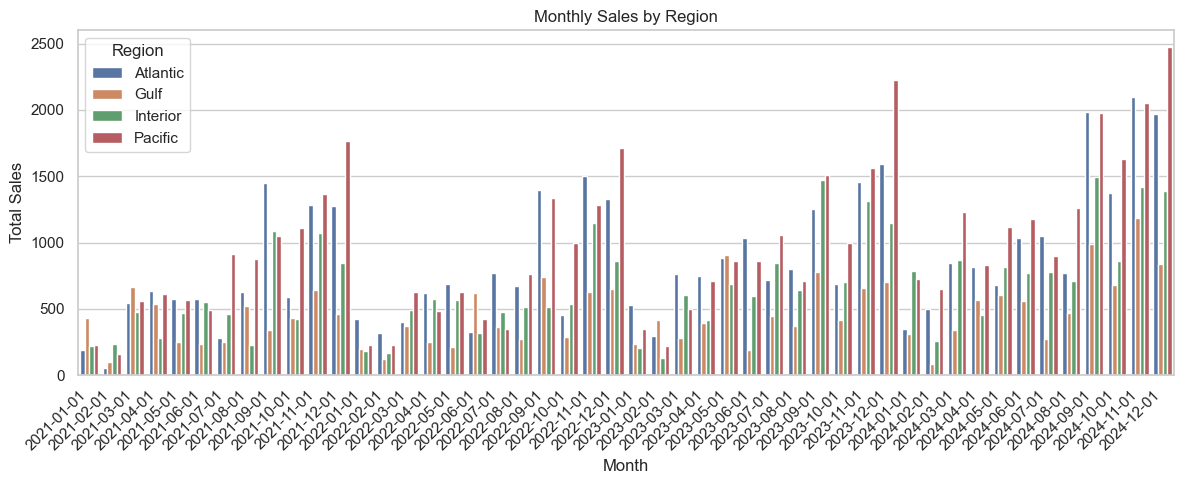

In [7]:
# Ensure matplotlib and seaborn are available in this kernel (imports may be in earlier cells)
if 'plt' not in globals():
    import matplotlib.pyplot as plt
if 'sns' not in globals():
    import seaborn as sns

# If sales_by_month_region wasn't created yet (this cell may run before the later cell that builds it),
# build the aggregation here so the plotting code can run without NameError.
if 'sales_by_month_region' not in globals():
    # Ensure the order date column exists and is datetime
    if "Order_Date" in df.columns:
        df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
    elif "Order Date" in df.columns:
        df["Order_Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
    else:
        raise KeyError("Order date column not found. Expected 'Order_Date' or 'Order Date'.")

    # Create a YearMonth column and aggregate Sales by month and region
    df["YearMonth"] = df["Order_Date"].dt.to_period("M").dt.to_timestamp()
    sales_by_month_region = (
        df
        .groupby(["YearMonth", "Region"], as_index=False)["Sales"]
        .sum()
    )

plt.figure(figsize=(12, 5))
sns.barplot(
    data=sales_by_month_region,
    x="YearMonth",
    y="Sales",
    hue="Region"          # one color per region
)

plt.title("Monthly Sales by Region")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


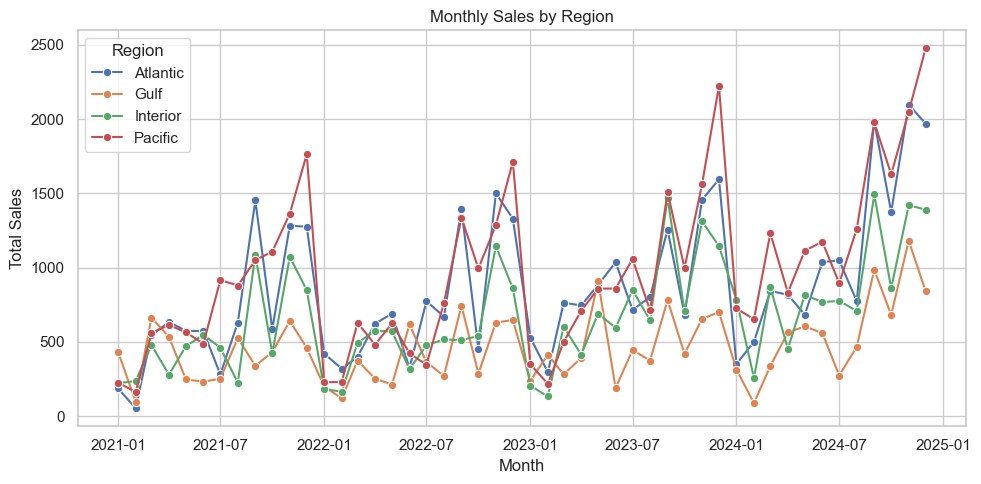

In [7]:
# Aggregate by Year-Month and Region
# handle either 'Order_Date' or 'Order Date' column names to avoid KeyError
if "Order_Date" in df.columns:
    df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
elif "Order Date" in df.columns:
    df["Order_Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
else:
    raise KeyError("Order date column not found. Expected 'Order_Date' or 'Order Date'.")

df["YearMonth"] = df["Order_Date"].dt.to_period("M").dt.to_timestamp()

sales_by_month_region = (
    df
    .groupby(["YearMonth", "Region"], as_index=False)["Sales"]
    .sum()
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=sales_by_month_region,
    x="YearMonth",
    y="Sales",
    hue="Region",      # separate line per Region
    marker="o"
)
plt.title("Monthly Sales by Region")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


# 3 Month moving average share by region 

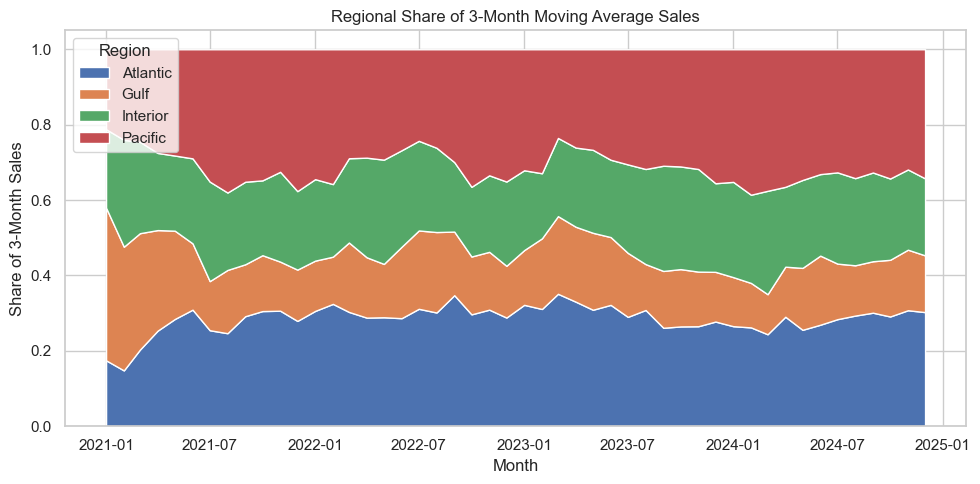

In [9]:
# Starting from sales_by_month_region with YearMonth, Region, Sales_3M

# 1. Compute total 3M sales per month
totals_3m = (
    sales_by_month_region
    .groupby("YearMonth", as_index=False)["Sales_3M"]
    .sum()
    .rename(columns={"Sales_3M": "Total_3M"})
)

# 2. Merge totals back and compute share
sales_share = sales_by_month_region.merge(totals_3m, on="YearMonth", how="left")
sales_share["Share_3M"] = sales_share["Sales_3M"] / sales_share["Total_3M"]

# 3. Pivot to wide format for stacked area plotting
share_pivot = sales_share.pivot(index="YearMonth", columns="Region", values="Share_3M")

# 4. Plot stacked area chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.stackplot(
    share_pivot.index,
    [share_pivot[col] for col in share_pivot.columns],
    labels=share_pivot.columns
)
plt.legend(title="Region", loc="upper left")
plt.title("Regional Share of 3-Month Moving Average Sales")
plt.xlabel("Month")
plt.ylabel("Share of 3-Month Sales")
plt.tight_layout()
plt.show()


# Small multiples :one panel per region 

<Figure size 1000x600 with 0 Axes>

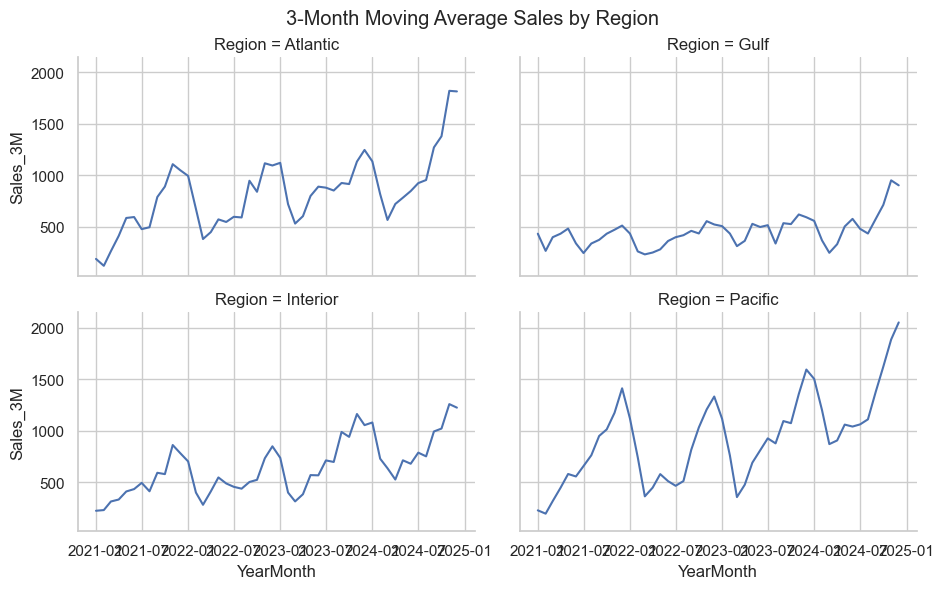

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.relplot(
    data=sales_by_month_region,
    x="YearMonth",
    y="Sales_3M",
    col="Region",
    kind="line",
    col_wrap=2,
    height=3,
    aspect=1.6
)
plt.subplots_adjust(top=0.9)
plt.suptitle("3-Month Moving Average Sales by Region")
plt.show()